# Modelo de Bateria

In [49]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import polars as ps

### Componentes e OVC em função do SoC

In [50]:
def r0(z):
    base = 700*10**(-6)
    return base*0.9+z*base*0.1

def r1(z):
    base = 0.5*10**(-3)
    return base*0.9+z*base*0.1

def c1(z):
    base = 15000
    return base*0.9+z*base*0.1

def r2(z):
    base = 80*10**(-6)
    return base*0.9+z*base*0.1

def c2(z):
    base = 5000
    return base*0.9+z*base*0.1

def OCV(z):
    base = 12
    return base*0.9+z*base*0.1

### Update dos valores

In [51]:
def update_z(z, Q, n, i, d_t):
    '''
    z: SoC
    Q: capacidade total (As)
    n: eficiência coulombiana/carga
    i: corrente (A)
    d_t: variação no tempo (s)
    '''
    d_h = d_t/3600
    z -= n*i*(d_h/Q)
    return max(z,0)

In [52]:
def update_v(z, i_r0, i_r1):
    return OCV(z) - i_r0*r0(z) - i_r1*r1(z)

In [53]:
#d_t em segundos nessa equação
def update_i_r1(z, i_r0, i_r1, d_t):
    e = np.exp(-d_t/(c1(z)*r1(z)))
    return i_r1*e+i_r0*(1-e)

### Loop de execução

In [54]:
z = 1 # SoC
Q = 100 # capacidade total (Ah) (100Ah)
d_t = 0.01 # variação no tempo (s)
n = 1 # eficiência coulombiana/carga
i_r1 = 0 # corrente (A)
i0 = 100 # corrente (A)

V = []
I1 = []
Z = []
pausa = int(3600/d_t)
descarga = int(pausa*0.1)
I0 = ([0.0]*pausa+[i0]*descarga)*20 # corrente (A)

for i_r0 in I0:
    if z <= 0:
        I0 = I0[:len(V)]
        break
    # Update dos valores
    v = update_v(z, i_r0, i_r1)
    z = update_z(z, Q, n, i_r0, d_t)
    i_r1 = update_i_r1(z, i_r0, i_r1, d_t)
    # Armazenamento dos valores
    V.append(v)
    Z.append(z)
    I1.append(i_r1)

t = np.arange(len(V))
df = ps.DataFrame(data={'t':t,'V': V, 'I0': I0, 'Z': Z})
df['dV'] = df['V'].diff()
df['dI'] = df['I0'].diff()

## Gráficos

In [55]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=df.to_pandas(), x='t', y='V')
sns.scatterplot(data=df.to_pandas(), x='t', y='V', style='I0', size='Z', color='red')
plt.ylabel('V')
plt.xlabel('Amostras')
plt.title('Tensão de saída')
plt.ylim([min(V), max(V)])
plt.xlim([0, len(V)])
plt.xticks(np.arange(0, len(V), 1200))
plt.grid()
plt.show()
plt.close()

### Extração de Parametros

### OVC

In [ ]:
# Filtra somente os pontos relevantes para a retirada do OCV
df_ovc = df.filter((ps.col('dI') > 0).shift(-1))[['t', 'V']]

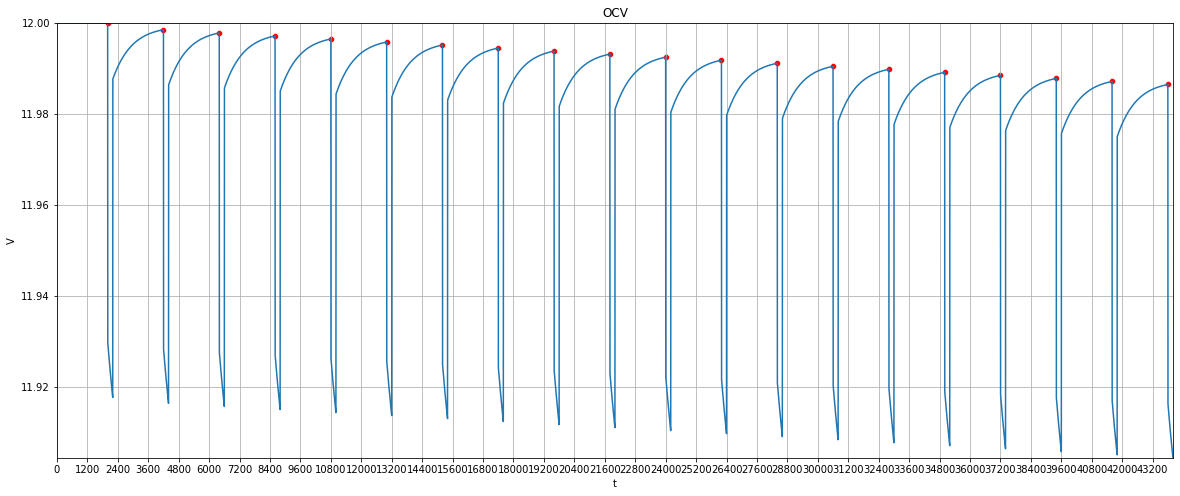

In [ ]:
plt.figure(figsize=(20, 8))
sns.scatterplot(data=df_ovc.to_pandas(), x='t', y='V', color='red')
sns.lineplot(data=df.to_pandas(), x='t', y='V')
plt.grid()
plt.title('OCV')
plt.ylim([min(V), max(V)])
plt.xlim([0, len(V)])
plt.xticks(np.arange(0, len(V), 1200))
plt.show()
plt.close()

### R0

In [ ]:
# Retira os pontos relevantes para determinar o R0
r0_hat = df.filter(
    ps.col('dI') < 0 # Somente pontos com a variação da corrente sendo negativa
).select([
    ps.col('t')-1, # t-1
    (ps.col('dV')/i0).alias('r0'), # r0
    ps.col('V') # r0
])

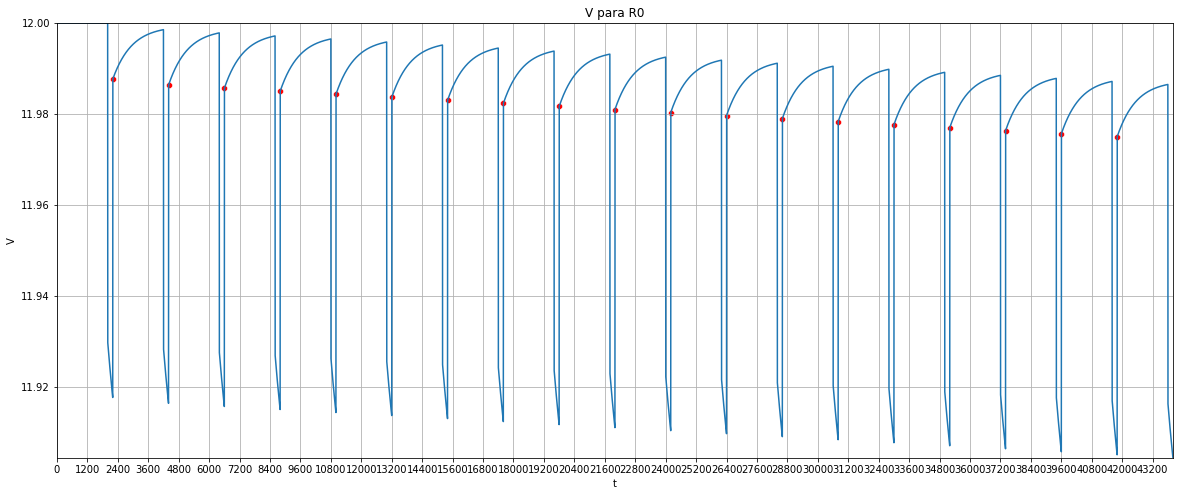

In [ ]:
# Pontos que foram usados para identificação de R0
plt.figure(figsize=(20, 8))
sns.scatterplot(data=r0_hat.to_pandas(), x='t', y='V', color='red')
sns.lineplot(data=df.to_pandas(), x='t', y='V')
plt.grid()
plt.title('V para R0')
plt.ylim([min(V), max(V)])
plt.xlim([0, len(V)])
plt.xticks(np.arange(0, len(V), 1200))
plt.show()
plt.close()

### Delimita o intervalo da curva

In [ ]:
# A curva começa na tensão utilizada para identificar o R0
r0_hat['tipo'] = np.zeros(len(r0_hat)) # 0 para inicio
df_c = r0_hat[['t','tipo']]
r0_hat = r0_hat.drop(['tipo'])

# E termina na tensão utilizada para identificar o OCV
df_ovc['tipo'] = np.ones(len(df_ovc)) # 1 para fim
df_c.extend(df_ovc[['t','tipo']])
df_ovc = df_ovc.drop(['tipo'])

df_c.sort('t',in_place=True)

# Dataframe intermediario com os pontos de R0 e OCV
df_c = df_c.select(
    [
        ps.col('t').shift(1).alias('t_inicio')+1,
        ps.col('t').alias('t_fim'),
        ps.col('tipo'),
    ]
).filter(ps.col('tipo')==1.0 # Filtra somente os pontos de fim
).filter(ps.col('t_inicio').is_not_null() # Retirar os valores nulos do inicio
).filter(ps.col('t_fim').is_not_null() # Retirar os valores nulos do fim
).select([ps.col('t_inicio'), ps.col('t_fim')]) # Colunas de interesse

### Determina o valor da constante de tempo - Tau

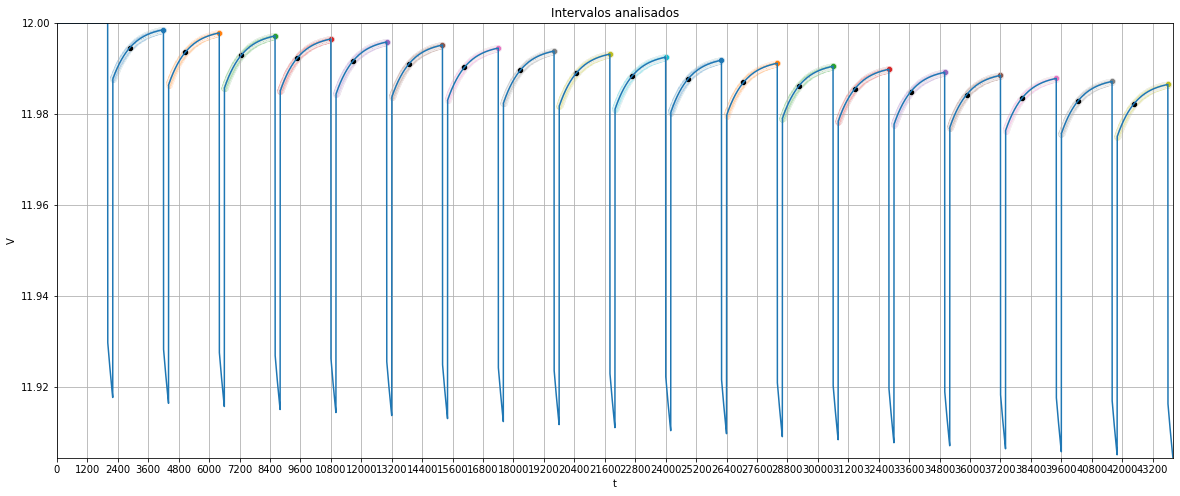

In [ ]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=df.to_pandas(), x='t', y='V')

tau = dict() # R1*C1

for t_inicio, t_fim in df_c.rows():
    # Entra a diferença entre o V para R0 e o V para OCV
    v0 = df.filter(ps.col('t')==t_inicio)['V'].max()
    vinf = df.filter(ps.col('t')==t_fim)['V'].max()
    dv = vinf-v0

    # Percorre todos os valores intermediarios entre t_inicio e t_fim
    for i in range(t_inicio, t_fim):
        # Determina o V para aquele ponto
        vx = df.filter(ps.col('t')==i)['V'].max()
        
        # Caso a diferença seja 63.212% de dv (equivalente a diferença após uma constante de tempo Tau)
        if vx-v0 >= 0.632120*dv:
            # Determina-se o periodo entre esse ponto e o inicio como a constante de tempo Tau
            tau[t_inicio-1] = (i-t_inicio-0.5)*d_t #Existe um problema, que a precisão deste valor é somente de 1s
            break

    # Plota o a curva positiva analisada
    if tau:
        a = df.filter(ps.col('t')>=t_inicio).filter(ps.col('t')<=t_fim)
        sns.scatterplot(data=a.to_pandas(), x='t', y='V')

        a = df.filter(ps.col('t')==i)
        sns.scatterplot(data=a.to_pandas(), x='t', y='V', color='black', markers='*')

plt.ylim([min(V), max(V)])
plt.xlim([0, len(V)])
plt.xticks(np.arange(0, len(V), 1200))
plt.title('Intervalos analisados')
plt.grid()
plt.show()
plt.close()   

### Determina o valor de R1

In [ ]:
r1_hat = dict()

for t_inicio, t_fim in df_c.rows():
    t = t_inicio-1 # Ajusta o tempo em relação a df_c
    # Encontra a diferença de tensão máxima entre o inicio e o fim do intervalo
    dv = (df[t:t_fim+1]['V'].max() - df[t:t_fim+1]['V'].min())
    # Encontra R1 para o intervalo através do valor de R0 e da diferença de tensão
    r1_hat[t] = dv/i0-r0_hat.filter(ps.col('t')==t)['r0'].max()

# Transforma R1 em um dataframe
r1_hat = ps.DataFrame({'t':list(r1_hat.keys()), 'r1':list(r1_hat.values())})

In [ ]:
c1_hat = dict()

for t_inicio, t_fim in df_c.rows():
    t = t_inicio-1 # Ajusta o tempo em relação a df_c
    # Pega o R1 correspondente ao intervalo
    r1_ = r1_hat.filter(ps.col('t')==t)['r1'].max()
    # C1 = Tau/R1
    c1_hat[t] = tau[t]/(r1_)

# Transforma C1 em um dataframe
c1_hat = ps.DataFrame({'t':list(c1_hat.keys()), 'c1':list(c1_hat.values())})

In [ ]:
df_ovc

t,V
i64,f64
1999,12.0
4199,11.998519
6399,11.9978
8599,11.997141
10799,11.996474
12999,11.995808
15199,11.995141
17399,11.994475
19599,11.993809


In [ ]:
c1_hat

t,c1
i64,f64
2199,61114.1447
4399,58023.633696
6599,57865.472578
8799,57854.607993
10999,57851.553313
13199,57848.913832
15399,57759.374932
17599,57756.762771
19799,57754.1507


In [ ]:
r1_hat

t,r1
i64,f64
2199,0.000109
4399,0.000115
6599,0.000115
8799,0.000115
10999,0.000115
13199,0.000115
15399,0.000115
17599,0.000115
19799,0.000115


In [ ]:
r0_hat

t,r0,V
i64,f64,f64
2199,0.000699,11.9876
4399,0.000699,11.9863
6599,0.000699,11.9856
8799,0.000699,11.984971
10999,0.000699,11.984304
13199,0.000699,11.983637
15399,0.000699,11.9829
17599,0.000699,11.982303
19799,0.000699,11.981636


In [ ]:
print(r0_hat['r0'].mean()-r0(0))
print(df_ovc['V'].mean()-OCV(0))
print(c1_hat['c1'].mean()-c1(0))
print(r1_hat['r1'].mean()-r1(0))

6.907518093143361e-05
1.192854281941699
44459.28833514713
-0.00033527835490378035


In [ ]:
max(tau.values())/7.5

0.8873333333333334

In [ ]:
c1(1)*r1(1)

7.5

In [ ]:
c1(0)*r1(0)

6.075

In [ ]:
tau

{2199: 6.655,
 4399: 6.655,
 6599: 6.655,
 8799: 6.655,
 10999: 6.655,
 13199: 6.655,
 15399: 6.6450000000000005,
 17599: 6.6450000000000005,
 19799: 6.6450000000000005,
 21999: 6.6450000000000005,
 24199: 6.6450000000000005,
 26399: 6.6450000000000005,
 28599: 6.6450000000000005,
 30799: 6.6450000000000005,
 32999: 6.6450000000000005,
 35199: 6.6450000000000005,
 37399: 6.6450000000000005,
 39599: 6.6450000000000005,
 41799: 6.6450000000000005}